In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2
import re
from hossam.util import *
from hossam.plot import *
from hossam.tensor import *
from hossam.regression import *
from hossam.classification import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
origin = my_read_excel('C:/Users/Jihwan/Desktop/01Class/수업자료/titanic.xlsx')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB
None

상위 5개 행
+----+---------------+------------+----------+-----------------------------------------------------+--------+-------+---------+---------+------------------+---------+---------+------------+
|    |   PassengerId |   Survived |  

In [3]:
df = origin.copy()

# 1. 생존 여부에 따른 평균 나이로 결측치 치환
mean_age_df = df[['Survived','Age']].groupby('Survived').mean()

for i in mean_age_df.index:
    mean_age = round(mean_age_df.loc[i]['Age'], 0)
    expr = (df['Survived'] == i) & (df['Age'].isna())
    df.loc[expr, 'Age'] = df.loc[expr, 'Age'].fillna(mean_age)

# 2. 히스토그램 구간에 따라 나이를 명목형으로 변환
hist, bins = np.histogram(df['Age'], bins=5)

df2 = df.copy()
df2.loc[ df2['Age'] <= 16, "Age"] = 0
df2.loc[ (df2['Age'] > 16) & (df2['Age'] <= 32), "Age"] = 1
df2.loc[ (df2['Age'] > 32) & (df2['Age'] <= 48), "Age"] = 2
df2.loc[ (df2['Age'] > 48) & (df2['Age'] <= 64), "Age"] = 3
df2.loc[ df2['Age'] > 64, "Age"] = 4

# 3. 객실 유무에 따른 명목형 변수 생성
df2['Has_Cabin'] = df2['Cabin'].apply(lambda x:  0 if type(x) == float else 1)
df2['Has_Cabin'].value_counts()

# 4. 가족 구성원 수 파생변수 생성
df2['FamilySize'] = df2['SibSp'] + df2['Parch'] + 1

# 5. 혼자 탑승했는지에 대한 파생변수 생성
df2['IsAlone'] = 0
df2.loc[df2['FamilySize'] == 1, 'IsAlone'] = 1

# 6. 생존 여부에 따른 탑승지 최빈값으로 결측치 치환
most_embarked_df = df2[['Survived','Embarked']].groupby('Survived').agg(Series.mode)

for i in most_embarked_df.index:
    most = most_embarked_df.loc[i]['Embarked']
    expr = (df2['Survived'] == i) & (df2['Embarked'].isna())
    df2.loc[expr, 'Embarked'] = df2.loc[expr, 'Embarked'].fillna(most)

# 7. 생존 여부에 따른 운임요금 평균으로 결측치 치환
mean_fare_df = df2[['Survived','Fare']].groupby('Survived').mean()

for i in mean_fare_df.index:
    mean_fare = mean_fare_df.loc[i]['Fare']
    expr = (df2['Survived'] == i) & (df2['Fare'].isna())
    df2.loc[expr, 'Fare'] = df2.loc[expr, 'Fare'].fillna(mean_fare)

# 8. 이름으로부터 호칭 파생변수 생성
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    
    if title_search:
        return title_search.group(1)
    
    return ""

df2['Title'] = df2['Name'].apply(get_title)

df2['Title'] = df2['Title'].replace(['Rev', 'Dr', 
                'Mlle', 'Major', 'Col', 'Countess', 'Capt', 'Ms', 
                'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer', 'Dona'], "Rare")

# 9. 데이터 라벨링
df3 = my_labelling(df2, 'Title', 'Embarked', 'Sex')

# 10. 운임요금 사분위수 구간에 따른 명목형 파생변수 생성
df3.loc[ df3['Fare'] <= 7.9, "Fare"] = 0
df3.loc[ (df2['Fare'] > 7.9) & (df3['Fare'] <= 14.5), "Fare"] = 1
df3.loc[ (df3['Fare'] > 14.5) & (df3['Fare'] <= 31.3), "Fare"] = 2
df3.loc[ df3['Fare'] > 31.3, "Fare"] = 3

# 11. 불필요한 컬럼 제거
drop_elements = ['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch']
df4 = df3.drop(drop_elements, axis = 1)

my_pretty_table(df4.head())

+---------+---------+
| Title   |   label |
|---------+---------|
| Master  |       0 |
| Miss    |       1 |
| Mr      |       2 |
| Mrs     |       3 |
| Rare    |       4 |
+---------+---------+
+------------+---------+
| Embarked   |   label |
|------------+---------|
| C          |       0 |
| Q          |       1 |
| S          |       2 |
+------------+---------+
+--------+---------+
| Sex    |   label |
|--------+---------|
| female |       0 |
| male   |       1 |
+--------+---------+
+----+---------------+------------+----------+-------+-------+--------+------------+-------------+--------------+-----------+---------+
|    |   PassengerId |   Survived |   Pclass |   Sex |   Age |   Fare |   Embarked |   Has_Cabin |   FamilySize |   IsAlone |   Title |
|----+---------------+------------+----------+-------+-------+--------+------------+-------------+--------------+-----------+---------|
|  0 |             1 |          0 |        3 |     1 |     1 |      0 |          2 |         

In [4]:
x_train, x_test, y_train, y_test = my_train_test_split(df4, 'Survived')
rows, cols = x_train.shape
rows, cols

(1047, 10)

In [5]:
df4.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Sex              int32
Age            float64
Fare           float64
Embarked         int32
Has_Cabin        int64
FamilySize       int64
IsAlone          int64
Title            int32
dtype: object

In [6]:
x_train, x_test, y_train, y_test = my_train_test_split(df4, yname='Survived')
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1047, 10), (262, 10), (1047,), (262,))

In [7]:
# model 객체 생성
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(x_train.shape[1], )))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 385 (1.50 KB)

 Trainable params: 385 (1.50 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 모델 학습
result = model.fit(
    x_train, y_train, epochs=500, validation_data=(x_test, y_test), verbose=0, 
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', patience=5, min_lr = 0.0001, 
                          verbose=0)])

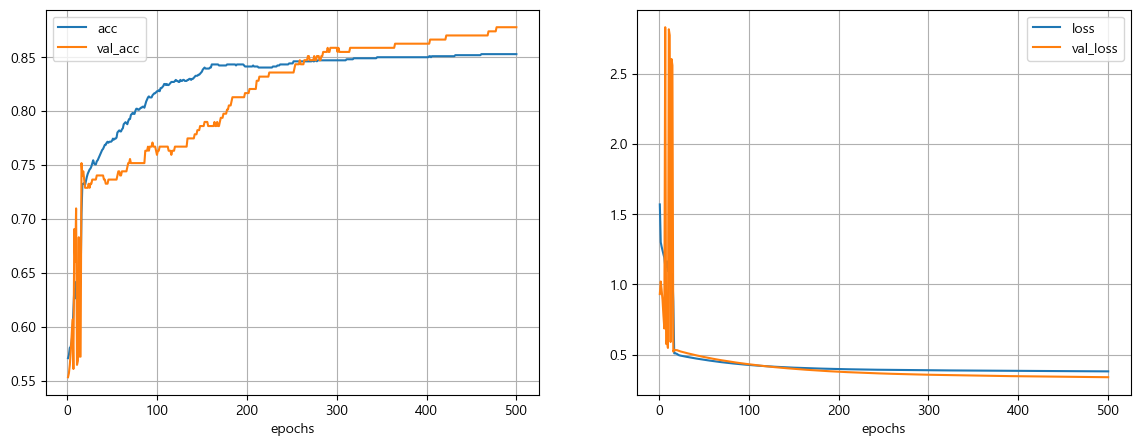

+----------+----------+----------+-----------+------------+-----------------+
|   epochs |      acc |     loss |   val_acc |   val_loss |   learning_rate |
|----------+----------+----------+-----------+------------+-----------------|
|        1 | 0.571156 |  1.57024 |  0.553435 |   0.931815 |           0.001 |
|        2 | 0.574021 |  1.30137 |  0.557252 |    1.02148 |           0.001 |
|        3 | 0.580707 |  1.26925 |  0.564885 |   0.961723 |           0.001 |
|        4 | 0.581662 |  1.24153 |  0.576336 |   0.889535 |           0.001 |
|        5 | 0.586437 |  1.21564 |  0.591603 |   0.779959 |           0.001 |
|        6 | 0.594078 |  1.19121 |   0.60687 |   0.686628 |           0.001 |
|        7 | 0.616046 |  1.13155 |  0.561069 |    2.83208 |           0.001 |
|        8 | 0.635148 |  1.12593 |   0.69084 |   0.576918 |           0.001 |
|        9 | 0.626552 |  1.16483 |  0.660305 |   0.603926 |           0.001 |
|       10 | 0.641834 |  1.09647 |  0.709924 |    0.54834 |     

In [9]:
tf_result(result, history_table=True)

In [10]:
test_pred = model.predict(x_test)
data_count, case_count = test_pred.shape
print('%d개의 검증 데이터가 %d개의 경우의 수를 갖는다.' % (data_count, case_count))
print(test_pred)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
262개의 검증 데이터가 1개의 경우의 수를 갖는다.
[[0.6459971 ]
 [0.7659806 ]
 [0.04894932]
 [0.0246047 ]
 [0.9578999 ]
 [0.0677283 ]
 [0.14916669]
 [0.04923942]
 [0.7609769 ]
 [0.908499  ]
 [0.04551388]
 [0.0352556 ]
 [0.81670296]
 [0.02868889]
 [0.8130312 ]
 [0.9274149 ]
 [0.742916  ]
 [0.9652063 ]
 [0.7729694 ]
 [0.58257174]
 [0.06076038]
 [0.56652725]
 [0.24107386]
 [0.41631496]
 [0.49188396]
 [0.61537135]
 [0.6877594 ]
 [0.6435647 ]
 [0.8539361 ]
 [0.02155804]
 [0.02645586]
 [0.02178653]
 [0.07253808]
 [0.29626554]
 [0.7638352 ]
 [0.03402248]
 [0.08125023]
 [0.9435409 ]
 [0.69282144]
 [0.14305717]
 [0.49563318]
 [0.08925871]
 [0.96422017]
 [0.174491  ]
 [0.03234444]
 [0.09441219]
 [0.7876538 ]
 [0.5748919 ]
 [0.7236124 ]
 [0.9187076 ]
 [0.647786  ]
 [0.7051501 ]
 [0.02892132]
 [0.0258777 ]
 [0.9471388 ]
 [0.901535  ]
 [0.61817324]
 [0.40463516]
 [0.06341004]
 [0.0506536 ]
 [0.02044993]
 [0.08289037]
 [0.03033654]
 [0.3170767 ]
 [0.0231825 ]
 [0.3825405 ]
 [0.0485

In [11]:
pred = test_pred.flatten()
pred

array([0.6459971 , 0.7659806 , 0.04894932, 0.0246047 , 0.9578999 ,
       0.0677283 , 0.14916669, 0.04923942, 0.7609769 , 0.908499  ,
       0.04551388, 0.0352556 , 0.81670296, 0.02868889, 0.8130312 ,
       0.9274149 , 0.742916  , 0.9652063 , 0.7729694 , 0.58257174,
       0.06076038, 0.56652725, 0.24107386, 0.41631496, 0.49188396,
       0.61537135, 0.6877594 , 0.6435647 , 0.8539361 , 0.02155804,
       0.02645586, 0.02178653, 0.07253808, 0.29626554, 0.7638352 ,
       0.03402248, 0.08125023, 0.9435409 , 0.69282144, 0.14305717,
       0.49563318, 0.08925871, 0.96422017, 0.174491  , 0.03234444,
       0.09441219, 0.7876538 , 0.5748919 , 0.7236124 , 0.9187076 ,
       0.647786  , 0.7051501 , 0.02892132, 0.0258777 , 0.9471388 ,
       0.901535  , 0.61817324, 0.40463516, 0.06341004, 0.0506536 ,
       0.02044993, 0.08289037, 0.03033654, 0.3170767 , 0.0231825 ,
       0.3825405 , 0.04858143, 0.08273119, 0.0254377 , 0.03157289,
       0.07229926, 0.6261108 , 0.06983034, 0.02138332, 0.02265

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.851003 |     0.877863 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.836364 |     0.862069 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.730159 |     0.862069 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0807175 |     0.109589 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.919283 |     0.890411 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.779661 |     0.862069 | 정밀도와 재현율의 조화평균                                |
+-------------------+

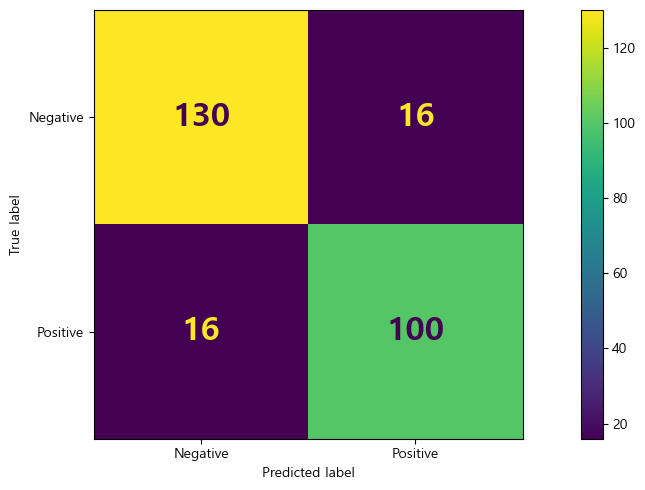


[Roc Curve]
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


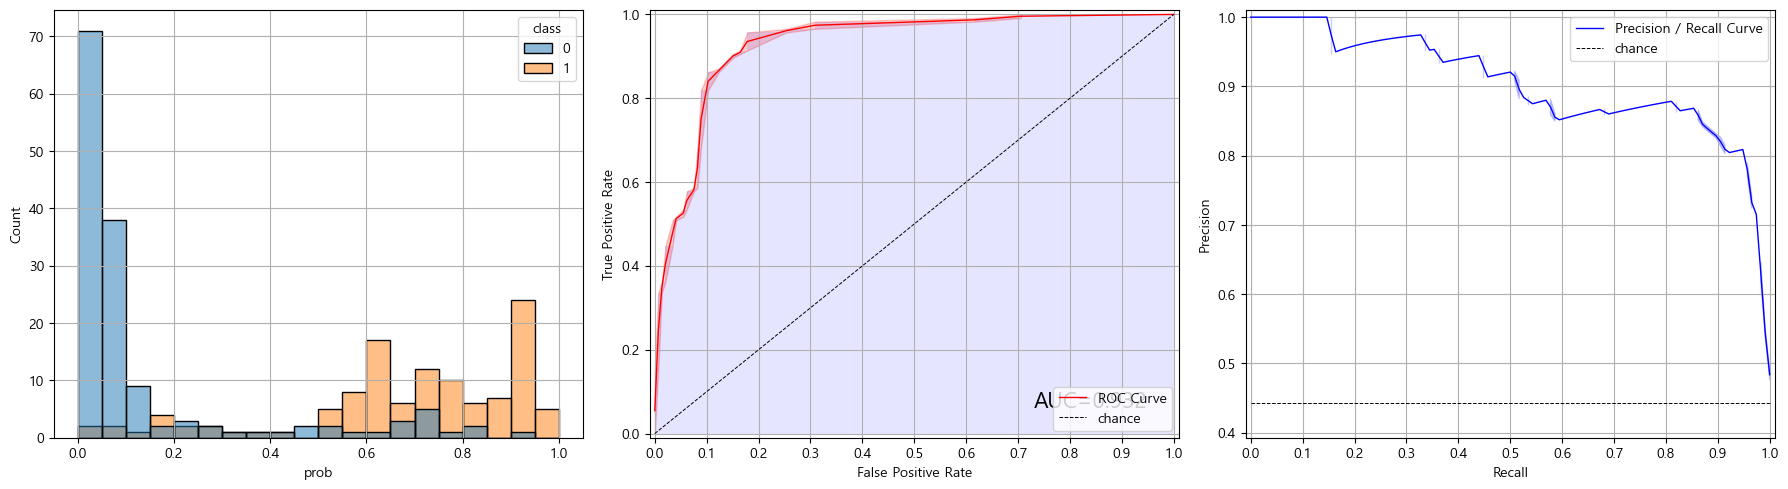


[학습곡선]
이 데이터는 학습곡선을 도출하는데 적합하지 않습니다.


+----+------------+-------------+---------+
|    | 종속변수   | 독립변수    |     VIF |
|----+------------+-------------+---------|
|  0 | Survived   | PassengerId | 4.16508 |
|  1 | Survived   | Pclass      | 10.6815 |
|  2 | Survived   | Sex         | 2.54442 |
|  3 | Survived   | Age         | 5.20572 |
|  4 | Survived   | Fare        |  6.0195 |
|  5 | Survived   | Embarked    | 4.56172 |
|  6 | Survived   | Has_Cabin   | 2.38375 |
|  7 | Survived   | FamilySize  | 5.27274 |
|  8 | Survived   | IsAlone     | 4.89487 |
|  9 | Survived   | Title       | 7.42394 |
+----+------------+-------------+---------+


In [12]:
my_classification_result(model, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
my_classification_report(model, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test) 

Trial 12 Complete [00h 00m 01s]
val_acc: 0.5648854970932007

Best val_acc So Far: 0.6374045610427856
Total elapsed time: 00h 00m 18s
+-------+----------+----------+
|       |      acc |     loss |
|-------+----------+----------|
| train | 0.756447 | 0.511924 |
| test  | 0.732824 | 0.530361 |
+-------+----------+----------+


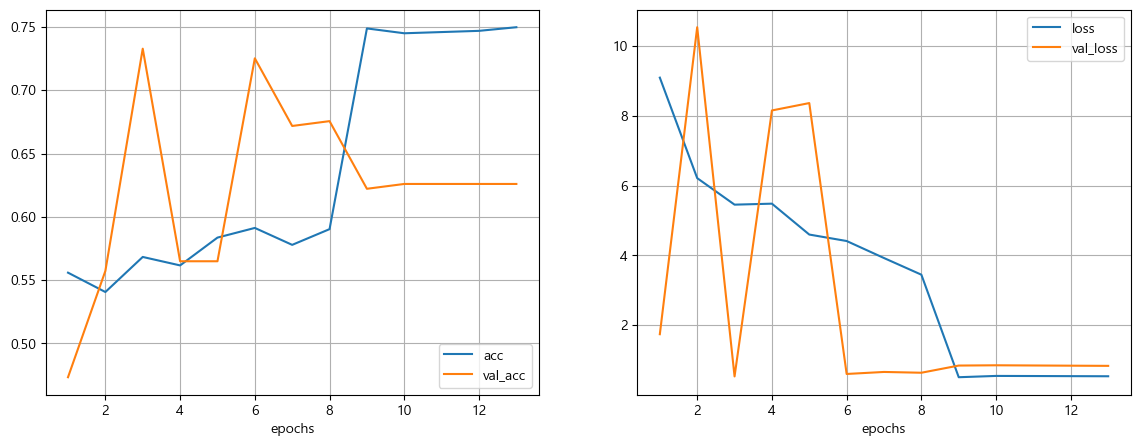

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.756447 |     0.732824 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.661417 |     0.691667 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.666667 |     0.715517 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |     0.192825 |     0.253425 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.807175 |     0.746575 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.664032 |      0.70339 | 정밀도와 재현율의 조화평균                                |
+-------------------+-

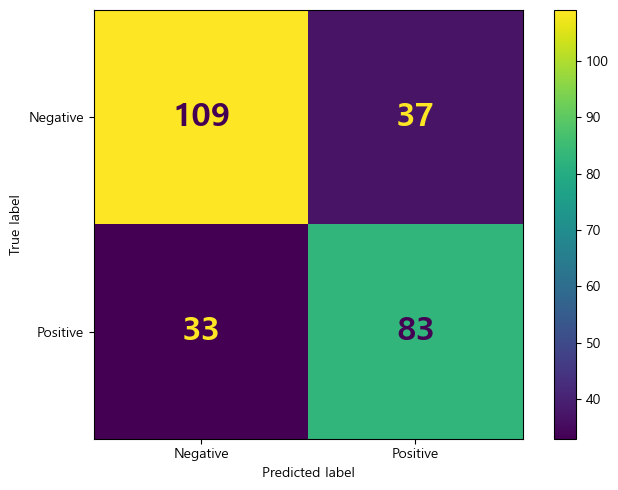


[Roc Curve]
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


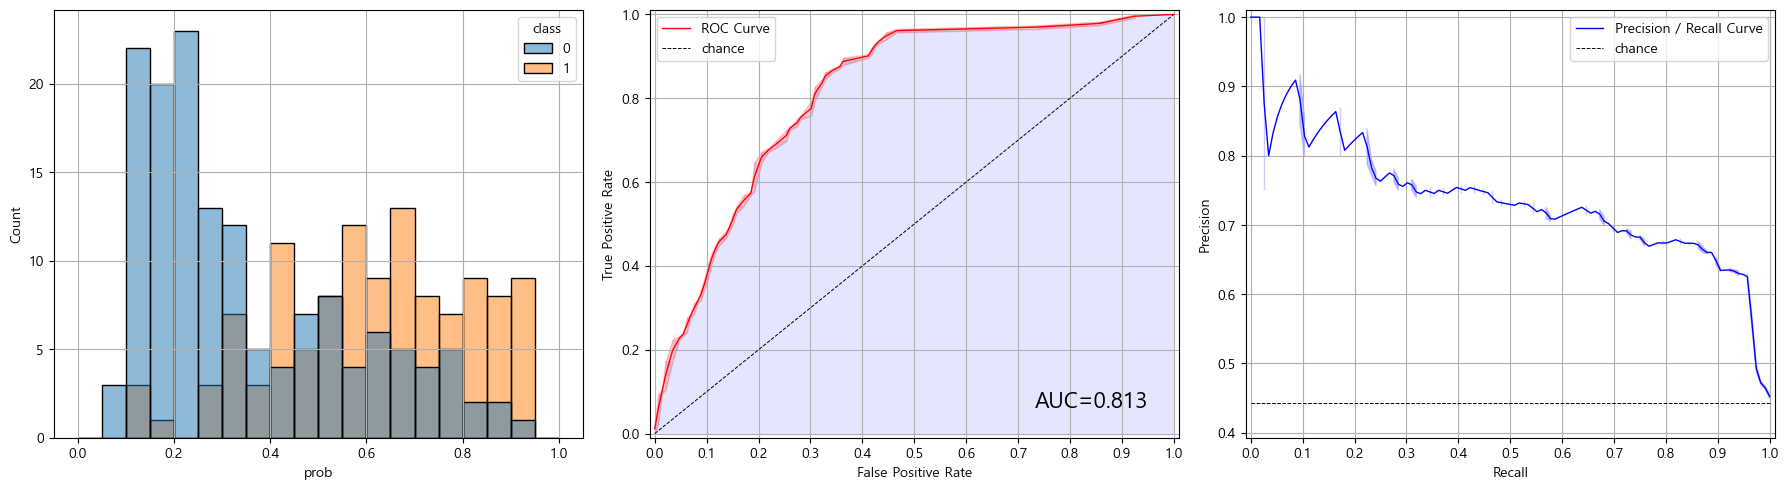


[학습곡선]
이 데이터는 학습곡선을 도출하는데 적합하지 않습니다.


+----+------------+-------------+---------+
|    | 종속변수   | 독립변수    |     VIF |
|----+------------+-------------+---------|
|  0 | Survived   | PassengerId | 4.16508 |
|  1 | Survived   | Pclass      | 10.6815 |
|  2 | Survived   | Sex         | 2.54442 |
|  3 | Survived   | Age         | 5.20572 |
|  4 | Survived   | Fare        |  6.0195 |
|  5 | Survived   | Embarked    | 4.56172 |
|  6 | Survived   | Has_Cabin   | 2.38375 |
|  7 | Survived   | FamilySize  | 5.27274 |
|  8 | Survived   | IsAlone     | 4.89487 |
|  9 | Survived   | Title       | 7.42394 |
+----+------------+-------------+---------+


<Sequential name=sequential_1, built=True>

In [13]:
my_tf_sigmoid(x_train, y_train, x_test, y_test)

Reloading Tuner from D:\tensor_hyperband\tf_hyperband_20240415144743\tuner0.json
+-------+----------+----------+
|       |     loss |      mae |
|-------+----------+----------|
| train | 0.117255 |  0.23775 |
| test  | 0.111189 | 0.235044 |
+-------+----------+----------+


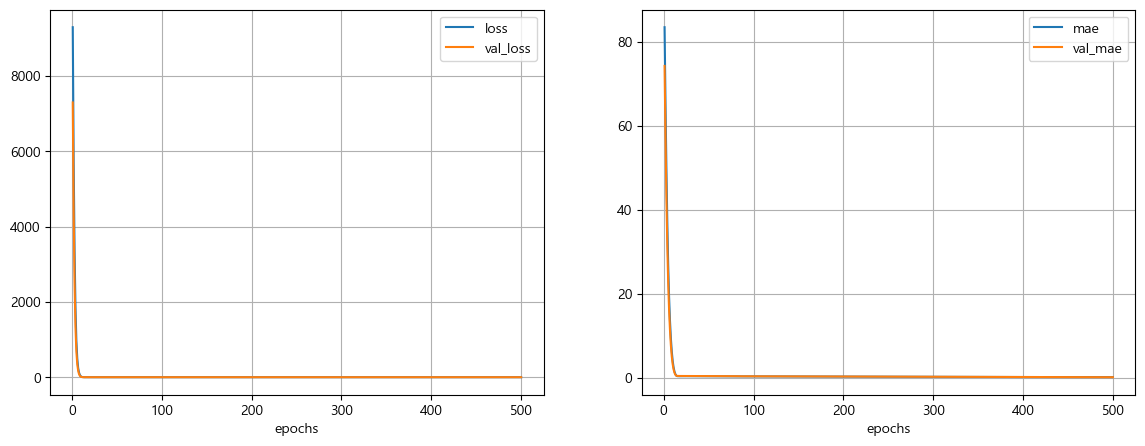

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 147us/step
[회귀분석 성능평가]
+-------------------------------+--------------+--------------+
|                               |   훈련데이터 |   검증데이터 |
|-------------------------------+--------------+--------------|
| 결정계수(R2)                  |     0.491716 |     0.549335 |
| 평균절대오차(MAE)             |      0.23775 |     0.235044 |
| 평균제곱오차(MSE)             |     0.117255 |     0.111189 |
| 평균오차(RMSE)                |     0.342425 |      0.33345 |
| 평균 절대 백분오차 비율(MAPE) |          inf |          inf |
| 평균 비율 오차(MPE)           |          nan |          nan |
+-------------------------------+--------------+--------------+

[학습곡선]
이 데이터는 학습곡선을 도출하는데 적합하지 않습니다.


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
+----+------------+-------------+---------+
|    | 종속변수   | 독립변수    |     VIF |
|----+------------+-------------+---------|
|  0 | Survived   | PassengerId | 4.16508 |
|  1 | Survived   | Pclass      | 10.6815 |
|  2 | Survived   | Sex 

<Sequential name=sequential_2, built=True>

In [14]:
my_tf_linear(x_train, y_train, x_test, y_test)